In [ ]:
# default_exp auto

In [ ]:
#export
import numpy as np
import pandas as pd

import pytorch_lightning as pl
#import logging
#logging.getLogger("pytorch_lightning").setLevel(logging.WARNING)

from hyperopt import hp
import neuralforecast as nf

## Base class

In [ ]:
#export
class AutoBaseModel(object):
    def __init__(self, n_time_out):
        super(AutoBaseModel, self).__init__()

        self.n_time_out = n_time_out

    def fit(self, Y_df, X_df, S_df, hyperopt_steps, loss_function_val, n_ts_val, results_dir,
            save_trials=False, loss_functions_test=None, n_ts_test=0, return_test_forecast=False, verbose=False):

        # Override space with data specific information
        self.space['n_series'] = hp.choice('n_series', [ Y_df['unique_id'].nunique() ])
        self.space['n_x'] = hp.choice('n_x', [ 0 if X_df is None else (X_df.shape[1]-2) ])
        self.space['n_s'] = hp.choice('n_s', [ 0 if S_df is None else (S_df.shape[1]-1) ])
        self.space['n_x_hidden'] = hp.choice('n_x_hidden', [ 0 if X_df is None else (X_df.shape[1]-2) ])
        self.space['n_s_hidden'] = hp.choice('n_s_hidden', [ 0 if S_df is None else (S_df.shape[1]-1) ])
        self.space['frequency'] = hp.choice('frequency', [ pd.infer_freq(Y_df['ds']) ])

        self.model, self.trials = nf.experiments.utils.hyperopt_tunning(space=self.space,
                                                             hyperopt_max_evals=hyperopt_steps,
                                                             loss_function_val=loss_function_val,
                                                             loss_functions_test=loss_functions_test,
                                                             S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                                             f_cols=[], ds_in_val=n_ts_val, 
                                                             ds_in_test=n_ts_test,
                                                             return_forecasts=return_test_forecast,
                                                             return_model=True,
                                                             save_trials=save_trials,
                                                             results_dir=results_dir,
                                                             step_save_progress=5,
                                                             verbose=verbose)
        
        return self

    def forecast(self, Y_df: pd.DataFrame, 
                 X_df: pd.DataFrame = None, S_df: pd.DataFrame = None,
                 batch_size: int =1, trainer: pl.Trainer =None) -> pd.DataFrame:
        
        return self.model.forecast(Y_df=Y_df, X_df=X_df, S_df=S_df, 
                                   batch_size=batch_size, trainer=trainer)

## AutoNHITS

In [ ]:
#export
class NHITS(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(NHITS, self).__init__(n_time_out)

        if space is None:
            space = nhits_space(n_time_out=n_time_out)
        self.space = space


def nhits_space(n_time_out: int, n_series: int=None, n_x: int=None, n_s: int=None, 
                frequency: str=None) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.

    Parameters
    ----------
    n_time_out: int
        Forecasting horizon.
    n_series: int
        Number of time-series.
    n_x: int
        Number of exogenous variables.
    n_s: int
        Number of static variables.
    frequency: str
        Frequency of time-seris.
    
    Returns
    ----------
    space: Dict
        Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
        'model':'nhits',
        'mode': 'simple',
        'n_time_in': hp.choice('n_time_in', [2*n_time_out, 3*n_time_out, 5*n_time_out]),
        'n_time_out': hp.choice('n_time_out', [n_time_out]),
        'n_x': hp.choice('n_x', [n_x]),
        'n_s': hp.choice('n_s', [n_s]),
        'shared_weights': hp.choice('shared_weights', [False]),
        'activation': hp.choice('activation', ['ReLU']),
        'initialization':  hp.choice('initialization', ['lecun_normal']),
        'stack_types': hp.choice('stack_types', [ 3*['identity'] ]),
        'constant_n_blocks': hp.choice('n_blocks', [ 1, 3 ]), # Constant n_blocks across stacks
        'constant_n_layers': hp.choice('n_layers', [ 2, 3 ]), # Constant n_layers across stacks
        'constant_n_mlp_units': hp.choice('n_mlp_units', [ 128, 256, 512, 1024 ]), # Constant n_mlp_units across stacks
        'n_x_hidden': hp.choice('n_x_hidden', [n_x] ),
        'n_s_hidden': hp.choice('n_s_hidden', [n_s] ),
        'n_pool_kernel_size': hp.choice('n_pool_kernel_size', [ 3*[1], 3*[2], 3*[4], 3*[8], [8, 4, 1], [16, 8, 1] ]),
        'n_freq_downsample': hp.choice('n_freq_downsample', [ [168, 24, 1], [24, 12, 1],
                                                                [180, 60, 1], [60, 8, 1],
                                                                [40, 20, 1] ]),
        'pooling_mode': hp.choice('pooling_mode', [ 'max' ]),
        'interpolation_mode': hp.choice('interpolation_mode', [ 'linear' ]),
        # Regularization and optimization parameters
        'batch_normalization': hp.choice('batch_normalization', [False]),
        'dropout_prob_theta': hp.choice('dropout_prob_theta', [ 0 ]),
        'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01]),
        'lr_decay': hp.choice('lr_decay', [0.5] ),
        'n_lr_decays': hp.choice('n_lr_decays', [3]), 
        'weight_decay': hp.choice('weight_decay', [0] ),
        'max_epochs': hp.choice('max_epochs', [None]),
        'max_steps': hp.choice('max_steps', [1_000, 3_000, 5_000]),
        'early_stop_patience': hp.choice('early_stop_patience', [10]),
        'eval_freq': hp.choice('eval_freq', [50]),
        'loss_train': hp.choice('loss', ['MAE']),
        'loss_hypar': hp.choice('loss_hypar', [0.5]),   
        'loss_valid': hp.choice('loss_valid', ['MAE']),
        # Data parameters
        'normalizer_y': hp.choice('normalizer_y', [None]),
        'normalizer_x': hp.choice('normalizer_x', [None]),
        'complete_windows':  hp.choice('complete_windows', [True]),
        'frequency': hp.choice('frequency', [frequency]),
        'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
        'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
        'batch_size': hp.choice('batch_size', [1]),
        'n_windows': hp.choice('n_windows', [32, 64, 128, 256, 512]),
        'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoNBEATS

In [ ]:
#export
class NBEATS(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(NBEATS, self).__init__(n_time_out)

        if space is None:
            space = nbeats_space(n_time_out=n_time_out)
        self.space = space

def nbeats_space(n_time_out: int, n_series: int, n_x: int, n_s: int, 
                 frequency: str) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.

    Parameters
    ----------
    n_time_out: int
        Forecasting horizon.
    n_series: int
        Number of time-series.
    n_x: int
        Number of exogenous variables.
    n_s: int
        Number of static variables.
    frequency: str
        Frequency of time-seris.
    
    Returns
    ----------
    space: Dict
        Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
        'model':'nbeats',
        'mode': 'simple',
        'n_time_in': hp.choice('n_time_in', [2*n_time_out, 3*n_time_out, 5*n_time_out]),
        'n_time_out': hp.choice('n_time_out', [n_time_out]),
        'n_x': hp.choice('n_x', [n_x]),
        'n_s': hp.choice('n_s', [n_s]),
        'shared_weights': hp.choice('shared_weights', [False]),
        'activation': hp.choice('activation', ['ReLU']),
        'initialization':  hp.choice('initialization', ['lecun_normal']),
        'stack_types': hp.choice('stack_types', [ 3*['identity'] ]),
        'constant_n_blocks': hp.choice('n_blocks', [ 1, 3 ]), # Constant n_blocks across stacks
        'constant_n_layers': hp.choice('n_layers', [ 2, 3 ]), # Constant n_layers across stacks
        'constant_n_mlp_units': hp.choice('n_mlp_units', [ 128, 256, 512, 1024 ]), # Constant n_mlp_units across stacks
        'n_x_hidden': hp.choice('n_x_hidden', [n_x] ),
        'n_s_hidden': hp.choice('n_s_hidden', [n_s] ),
        # Regularization and optimization parameters
        'batch_normalization': hp.choice('batch_normalization', [False]),
        'dropout_prob_theta': hp.choice('dropout_prob_theta', [ 0 ]),
        'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01]),
        'lr_decay': hp.choice('lr_decay', [0.5] ),
        'n_lr_decays': hp.choice('n_lr_decays', [3]), 
        'weight_decay': hp.choice('weight_decay', [0] ),
        'max_epochs': hp.choice('max_epochs', [None]),
        'max_steps': hp.choice('max_steps', [1_000, 3_000, 5_000]),
        'early_stop_patience': hp.choice('early_stop_patience', [10]),
        'eval_freq': hp.choice('eval_freq', [50]),
        'loss_train': hp.choice('loss', ['MAE']),
        'loss_hypar': hp.choice('loss_hypar', [0.5]),                
        'loss_valid': hp.choice('loss_valid', ['MAE']),
        # Data parameters
        'normalizer_y': hp.choice('normalizer_y', [None]),
        'normalizer_x': hp.choice('normalizer_x', [None]),
        'complete_windows':  hp.choice('complete_windows', [True]),
        'frequency': hp.choice('frequency', [frequency]),
        'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
        'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
        'batch_size': hp.choice('batch_size', [1]),
        'n_windows': hp.choice('n_windows', [32, 64, 128, 256, 512]),
        'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoRNN

In [ ]:
#export
class RNN(AutoBaseModel):
    def __init__(self, n_time_out, space=None):
        super(RNN, self).__init__(n_time_out)

        if space is None:
            space = rnn_space(n_time_out=n_time_out)
        self.space = space

def rnn_space(n_time_out: int, n_series: int, n_x: int, n_s: int, 
              frequency: str) -> dict:
    """
    Suggested hyperparameters search space for tuning. To be used with hyperopt library.

    Parameters
    ----------
    n_time_out: int
        Forecasting horizon.
    n_series: int
        Number of time-series.
    n_x: int
        Number of exogenous variables.
    n_s: int
        Number of static variables.
    frequency: str
        Frequency of time-seris.
    
    Returns
    ----------
    space: Dict
        Dictionary with search space for hyperopt library.
    """

    space= {# Architecture parameters
        'model':'rnn',
        'mode': 'full',
        'n_time_in': hp.choice('n_time_in', [1*n_time_out, 2*n_time_out, 3*n_time_out]),
        'n_time_out': hp.choice('n_time_out', [n_time_out]),
        'n_x': hp.choice('n_x', [n_x]),
        'n_s': hp.choice('n_s', [n_s]),
        'cell_type': hp.choice('cell_type', ['LSTM', 'GRU']),
        'state_hsize': hp.choice('state_hsize', [10, 20, 50, 100]),
        'dilations': hp.choice('dilations', [ [[1, 2]], [[1, 2, 4, 8]], [[1,2],[4,8]] ]),
        'add_nl_layer': hp.choice('add_nl_layer', [ False ]),
        'sample_freq': hp.choice('sample_freq', [n_time_out]),
        # Regularization and optimization parameters
        'learning_rate': hp.choice('learning_rate', [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]),
        'lr_decay': hp.choice('lr_decay', [0.5] ),
        'n_lr_decays': hp.choice('n_lr_decays', [3]), 
        'gradient_eps': hp.choice('gradient_eps', [1e-8]),
        'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10]),
        'weight_decay': hp.choice('weight_decay', [0]),
        'noise_std': hp.choice('noise_std', [0.001]),
        'max_epochs': hp.choice('max_epochs', [None]),
        'max_steps': hp.choice('max_steps', [500, 1000]),
        'early_stop_patience': hp.choice('early_stop_patience', [10]),
        'eval_freq': hp.choice('eval_freq', [50]),
        'loss_train': hp.choice('loss', ['MAE']),
        'loss_hypar': hp.choice('loss_hypar', [0.5]),                
        'loss_valid': hp.choice('loss_valid', ['MAE']),
        # Data parameters
        'normalizer_y': hp.choice('normalizer_y', [None]),
        'normalizer_x': hp.choice('normalizer_x', [None]),
        'complete_windows':  hp.choice('complete_windows', [True]),
        'frequency': hp.choice('frequency', [frequency]),
        'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [1]),
        'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [1]),
        'batch_size': hp.choice('batch_size', [16, 32, 64]),
        'n_windows': hp.choice('n_windows', [None]),
        'random_seed': hp.quniform('random_seed', 1, 20, 1)}

    return space

## AutoNF

In [ ]:
#export
def auto(config_dict: dict, 
         Y_df: pd.DataFrame, X_df: pd.DataFrame, S_df: pd.DataFrame,
         loss_function_val: callable, loss_functions_test: dict, 
         forecast_horizon: int, ts_in_val: int, ts_in_test: int,
         results_dir: str,
         return_forecasts: bool = False,
         test_auto: bool = False, verbose: bool = False):
    """
    Auto hyperparameter tuning function.

    Parameters
    ----------
    config_dict: Dict
        Dictionary with configuration. Keys should be name of models.
        For each model specify the hyperparameter space 
        (None will use default suggested space), hyperopt steps and timeout.
    Y_df: pd.DataFrame
        Target time series with columns ['unique_id', 'ds', 'y'].
    X_df: pd.DataFrame
        Exogenous time series with columns ['unique_id', 'ds', 'y'].
    S_df: pd.DataFrame
        Static exogenous variables with columns ['unique_id', 'ds']. 
        and static variables. 
    loss_function_val: function
        Loss function used for validation.
    loss_functions_test: Dictionary
        Loss functions used for test evaluation. 
        (function name: string, function: fun)
    forecast_horizon: int
        Forecast horizon
    ts_in_val: int
        Number of timestamps in validation.
    ts_in_test: int
        Number of timestamps in test.
    return_forecasts: bool
        If true return forecast on test.
    return_model: bool
        If true return model.
    test_auto: bool
        If true, will only run one training step and hyperopt iteration for each model. 
        For testing purposes, to ensure your pipeline will finish running, without waiting.
    verbose:
        If true, will print summary of dataset, model and training.
    """

    if test_auto:
        print('WARNING: test_auto=True, MODELS WILL NOT BE TRAINED PROPERLY!')

    # Data characteristics
    n_series = Y_df['unique_id'].nunique()
    n_x = len(X_df.columns)-2 if X_df is not None else 0
    n_s = len(S_df.columns)-1 if S_df is not None else 0
    frequency = pd.infer_freq(Y_df['ds'])

    # Hyperopt
    models = config_dict.keys()
    output_dict = {}
    best_model = None
    best_loss = np.inf
    for model_str in models:
        print('MODEL:', model_str)
        model_config = config_dict[model_str]

        hyperopt_steps = model_config['hyperopt_steps'] if (test_auto==False) else 1

        if model_config['space'] is None:
            # If hyperparameter space is None, use predefined space for the model
            # Available spaces, [N-BEATS, N-HiTS, RNN]
            space = instantiate_space(model=model_str, n_time_out=forecast_horizon, 
                                      n_series=n_series, n_x=n_x, n_s=n_s, 
                                      frequency=frequency, test=test_auto)
        else:
            space = model_config['space']
        
        # Run automated hyperparameter optimization
        results_dir_model = f'{results_dir}/{model_str}'
        model, trials = nf.experiments.utils.hyperopt_tunning(space=space,
                                                                hyperopt_max_evals=hyperopt_steps,
                                                                loss_function_val=loss_function_val,
                                                                loss_functions_test=loss_functions_test,
                                                                S_df=S_df, Y_df=Y_df, X_df=X_df, 
                                                                f_cols=[], ds_in_val=ts_in_val, 
                                                                ds_in_test=ts_in_test,
                                                                return_forecasts=return_forecasts,
                                                                return_model=True,
                                                                save_trials=False,
                                                                results_dir=results_dir_model,
                                                                step_save_progress=0,
                                                                verbose=verbose)

        model_output = {'best_mc': trials.best_trial['result']['mc'],
                        'run_time': trials.best_trial['result']['run_time'],
                        'best_val_loss': trials.best_trial['result']['loss']}

        # Return model
        model_output['model'] = model

        # Return test losses
        if ts_in_test > 0:
            model_output['best_test_loss'] = trials.best_trial['result']['test_losses']

        # Return test forecasts
        if (return_forecasts) and (ts_in_test > 0):
            model_output['y_hat'] = trials.best_trial['result']['forecasts_test']['test_y_hat']
            model_output['y_true'] = trials.best_trial['result']['forecasts_test']['test_y_true']

        # Improvement
        optimization_times = [trials.trials[0]['result']['loss']]
        optimization_losses = [trials.trials[0]['result']['run_time']]
        for i in range(1, len(trials)):
            loss = trials.trials[i]['result']['loss']
            time = trials.trials[i]['result']['run_time']

            if loss > np.min(optimization_losses):
                loss = np.min(optimization_losses)
            optimization_losses.append(loss)
            optimization_times.append(np.sum(optimization_times)+time)

        model_output['optimization_losses'] = optimization_losses
        model_output['optimization_times'] = optimization_times
    
        # Append to dict
        output_dict[model_str] = model_output

        if trials.best_trial['result']['loss'] < best_loss:
            best_model = model
            best_loss = trials.best_trial['result']['loss']

    return best_model, output_dict

In [ ]:
#export
def instantiate_space(model, n_time_out, n_series, n_x, n_s, frequency, test):
    assert model in ['nbeats', 'nhits', 'rnn'], f'Invalid model {model}'
    
    if model == 'nbeats':
        space = nbeats_space(n_time_out=n_time_out, n_series=n_series, 
                             n_x=n_x, n_s=n_s, frequency=frequency)
    elif model == 'nhits':
        space = nhits_space(n_time_out=n_time_out, n_series=n_series, 
                            n_x=n_x, n_s=n_s, frequency=frequency)
    elif model == 'rnn':
        space = rnn_space(n_time_out=n_time_out, n_series=n_series,
                          n_x=n_x, n_s=n_s, frequency=frequency)

    if test:
        space['max_steps'] = hp.choice('max_steps', [1])
        space['max_epochs'] = hp.choice('max_epochs', [None])
    
    return space

# Examples

The forecasting task we selected is to predict the number of patients with influenza-like illnesses from the [US CDC dataset](https://gis.cdc.gov/grasp/fluview/fluportaldashboard.html), the dataset contains 7 target variables, and has 966 weeks of history.

We will be creating point forecasts with N-BEATS, N-HiTS and RNN models. The predictive features will be the autoregressive features. More information on the dataset can be found in the [N-HiTS paper](https://arxiv.org/abs/2201.12886).

Table of Contents
1.   [Installing NeuralForecast Library](#cell-1)
2.   [Data Loading and Processing](#cell-2)
3.   [Define Hyperparameter Space](#cell-3)
4.   [Hyperparameter Tuning](#cell-4)
5.   [Evaluate Results](#cell-5)

<a name="cell-1"></a>
### 1. Installing Neuralforecast library

You can install the released version of NeuralForecast from the Python package index with:

In [ ]:
#%%capture
#!pip install neuralforecast
#!pip install matplotlib

import matplotlib.pyplot as plt
from neuralforecast.data.datasets.long_horizon import LongHorizon

<a name="cell-2"></a>
### 2. Data Loading and Processing

For this example we keep 10% of the observations as validation and use the latest 20% of the observations as the test set. To do so we use the sample_mask and declare the windows that will be used to train, and validate the model.

In [ ]:
Y_df, _, _ = LongHorizon.load(directory='./', group='ILI')
Y_df.head()

,unique_id,ds,y
0,% WEIGHTED ILI,2002-01-01,-0.421499
1,% WEIGHTED ILI,2002-01-08,-0.331239
2,% WEIGHTED ILI,2002-01-15,-0.342763
3,% WEIGHTED ILI,2002-01-22,-0.199782
4,% WEIGHTED ILI,2002-01-29,-0.218426


In [ ]:
n_series = len(Y_df.unique_id.unique())
n_time = len(Y_df.ds.unique()) # dataset is balanced

n_ts_test = 193
n_ts_val = 97

print('n_time', n_time)
print('n_series', n_series)
print('n_ts_test', n_ts_test)
print('n_ts_val', n_ts_val)

n_time 966
n_series 7
n_ts_test 193
n_ts_val 97


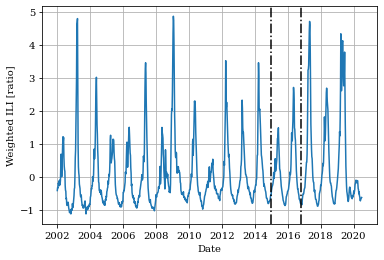

In [ ]:
# unique_id \in ['% WEIGHTED ILI', '%UNWEIGHTED ILI', 'AGE 0-4', 
#                'AGE 5-24', 'ILITOTAL', 'NUM. OF PROVIDERS', 'OT']
y_plot = Y_df[Y_df.unique_id=='% WEIGHTED ILI'].y.values
x_plot = pd.to_datetime(Y_df[Y_df.unique_id=='% WEIGHTED ILI'].ds).values

plt.plot(x_plot, y_plot)
plt.axvline(x_plot[n_time-n_ts_val-n_ts_test], color='black', linestyle='-.')
plt.axvline(x_plot[n_time-n_ts_test], color='black', linestyle='-.')
plt.ylabel('Weighted ILI [ratio]')
plt.xlabel('Date')
plt.grid()
plt.show()
plt.close()

### 3.0 auto.NHITS

In [ ]:
auto_nhits = NHITS(n_time_out=24)
auto_nhits.space['max_steps'] = hp.choice('max_steps', [1]) # Override max_steps for faster example

In [ ]:
auto_nhits.fit(Y_df=Y_df, X_df=None, S_df=None, hyperopt_steps=2,
               n_ts_val=n_ts_val,
               n_ts_test=n_ts_test,
               results_dir='./results/autonhits',
               save_trials=True,
               loss_function_val=nf.losses.numpy.mae,
               loss_functions_test={'mae':nf.losses.numpy.mae,
                                    'mse':nf.losses.numpy.mse},
               return_test_forecast=True,
               verbose=True)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.015280 seconds
INFO:hyperopt.tpe:TPE using 0 trials



activation                                          ReLU
batch_normalization                                False
batch_size                                             1
complete_windows                                    True
constant_n_blocks                                      1
constant_n_layers                                      3
constant_n_mlp_units                                 128
dropout_prob_theta                                     0
early_stop_patience                                   10
eval_freq                                             50
frequency                                           None
idx_to_sample_freq                                     1
initialization                              lecun_normal
interpolation_mode                                linear
learning_rate                                       0.01
loss_hypar                                           0.5
loss_train                                           MAE
loss_valid                    

INFO:root:Train Validation splits

INFO:root:                                       ds            
                                      min         max
unique_id         sample_mask                        
% WEIGHTED ILI    0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
%UNWEIGHTED ILI   0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
AGE 0-4           0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
AGE 5-24          0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
ILITOTAL          0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
NUM. OF PROVIDERS 0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
OT                0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
INFO:root:
Total data 			6762 time st

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/opt/anaconda3/envs/neuralforecast/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-up3bu5e5/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)

/Users/kingtzolivares/Desktop/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '



Predicting: 1it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

 50%|█████     | 1/2 [00:01<00:01,  1.48s/trial, best loss: 0.796950101852417]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.027597 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 0.796950



activation                                          ReLU                      
batch_normalization                                False
batch_size                                             1
complete_windows                                    True
constant_n_blocks                                      3
constant_n_layers                                      2
constant_n_mlp_units                                 512
dropout_prob_theta                                     0
early_stop_patience                                   10
eval_freq                                             50
frequency                                           None
idx_to_sample_freq                                     1
initialization                              lecun_normal
interpolation_mode                                linear
learning_rate                                      0.005
loss_hypar                                           0.5
loss_train                                           MAE
loss_val

INFO:root:Train Validation splits

INFO:root:                                       ds            
                                      min         max
unique_id         sample_mask                        
% WEIGHTED ILI    0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
%UNWEIGHTED ILI   0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
AGE 0-4           0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
AGE 5-24          0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
ILITOTAL          0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
NUM. OF PROVIDERS 0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
OT                0            2014-12-16  2020-06-30
                  1            2002-01-01  2014-12-09
INFO:root:
Total data 			6762 time st

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

/Users/kingtzolivares/Desktop/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '



Predicting: 1it [00:00, ?it/s]

Predicting: 1it [00:00, ?it/s]

100%|██████████| 2/2 [00:02<00:00,  1.41s/trial, best loss: 0.796950101852417]


In [ ]:
forecasts = auto_nhits.forecast(Y_df=Y_df)
forecasts

INFO:root:Train Validation splits

INFO:root:                                      ds           
                                     min        max
unique_id         sample_mask                      
% WEIGHTED ILI    0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
%UNWEIGHTED ILI   0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
AGE 0-4           0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
AGE 5-24          0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
ILITOTAL          0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
NUM. OF PROVIDERS 0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
OT                0           2002-01-01 2020-06-30
                  1           2020-07-01 2020-07-24
INFO:root:
Total data 			6930 time stamps 
Available percentage=100.0, 

Predicting: 0it [00:00, ?it/s]

,unique_id,ds,y
0,% WEIGHTED ILI,2020-07-01,-0.911240
1,% WEIGHTED ILI,2020-07-02,-0.917064
2,% WEIGHTED ILI,2020-07-03,-0.773354
3,% WEIGHTED ILI,2020-07-04,-0.873163
4,% WEIGHTED ILI,2020-07-05,-0.866344
...,...,...,...
163,OT,2020-07-20,2.660071
164,OT,2020-07-21,1.609160
165,OT,2020-07-22,2.321505
166,OT,2020-07-23,2.165904


<a name="cell-3"></a>
### 3. Define Hyperparameter Space

A temporal train-evaluation split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In this case we set the space to `None`, that implicitly uses the predefined model space, but the space can be specified as a dictionary following the conventions of the [Hyperopt package](https://github.com/hyperopt/hyperopt).

In [ ]:
config_dict = {'nbeats':
                       {'space': None, # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       },
               'nhits':
                       {'space': None,  # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       },
                'rnn':
                       {'space': None,  # Use default
                        'hyperopt_steps': 5,
                        'timeout': 60*1
                       }
              }

<a name="cell-4"></a>
### 4. Hyperparameter Tuning

A temporal train-validation-test (676,97,193) split procedure allows us to estimate the model’s generalization performance on future data unseen by the model. We use the train set to optimize the model parameters, and the validation  and test sets to evaluate the accuracy of the model’s predictions.

In [ ]:
forecast_horizon = 24
best_model, results = auto(config_dict=config_dict,
                           Y_df=Y_df, X_df=None, S_df=None,
                           loss_function_val=nf.losses.numpy.mae, 
                           loss_functions_test={'mae':nf.losses.numpy.mae,
                                                'mse':nf.losses.numpy.mse},
                           forecast_horizon=forecast_horizon, ts_in_val=n_ts_val, ts_in_test=n_ts_test,
                           results_dir='./results/auto',
                           return_forecasts=True,
                           test_auto=True,
                           verbose=False)

INFO:hyperopt.tpe:build_posterior_wrapper took 0.014874 seconds
INFO:hyperopt.tpe:TPE using 0 trials


MODEL: nbeats


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/Users/kingtzolivares/Desktop/neuralforecast/neuralforecast/data/tsloader.py:47: UserWarning: This class wraps the pytorch `DataLoader` with a special collate function. If you want to use yours simply use `DataLoader`. Removing collate_fn
  'This class wraps the pytorch `DataLoader` with a '
INFO:hyperopt.tpe:build_posterior_wrapper took 0.012125 seconds
INFO:hyperopt.tpe:TPE using 0 trials


MODEL: nhits


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
INFO:hyperopt.tpe:build_posterior_wrapper took 0.012913 seconds
INFO:hyperopt.tpe:TPE using 0 trials


MODEL: rnn


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Text(0, 0.5, 'val loss')

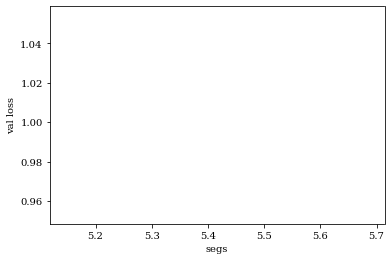

In [ ]:
time   = results['nbeats']['optimization_times']
losses = results['nbeats']['optimization_losses']
plt.plot(time, losses)
plt.xlabel('segs')
plt.ylabel('val loss')

<a name="cell-5"></a>
### 5. Evaluate Results

Here we wrangle the numpy predictions to evaluate and plot the predictions.

In [ ]:
y_hat_nhits  = results['nhits']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_hat_nbeats = results['nbeats']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_hat_rnn    = results['rnn']['y_hat']#.reshape(n_series, forecast_horizon, ts_in_test)
y_true       = results['nbeats']['y_true']#.reshape(forecast_horizon,n_series, -1)

print('\n Original Shapes')
print('1. y_hat_nhits.shape', y_hat_nhits.shape)
print('1. y_hat_nbeats.shape', y_hat_nbeats.shape)
print('1. y_hat_rnn.shape', y_hat_rnn.shape)
print('1. y_true.shape', y_true.shape)

y_hat_nbeats = results['nbeats']['y_hat'].reshape((n_series,
                                                   170, forecast_horizon))
y_hat_nhits = results['nhits']['y_hat'].reshape((n_series,
                                                 170, forecast_horizon))
y_true = results['nbeats']['y_true'].reshape((n_series,
                                              170, forecast_horizon))

print('\n Wrangled Shapes')
print('2. y_hat_nhits.shape', y_hat_nhits.shape)
print('2. y_hat_nbeats.shape', y_hat_nbeats.shape)
print('2. y_hat_rnn.shape', y_hat_rnn.shape)
print('2. y_true.shape', y_true.shape)


 Original Shapes
1. y_hat_nhits.shape (1190, 24)
1. y_hat_nbeats.shape (1190, 24)
1. y_hat_rnn.shape (7, 8, 24)
1. y_true.shape (1190, 24)

 Wrangled Shapes
2. y_hat_nhits.shape (7, 170, 24)
2. y_hat_nbeats.shape (7, 170, 24)
2. y_hat_rnn.shape (7, 8, 24)
2. y_true.shape (7, 170, 24)


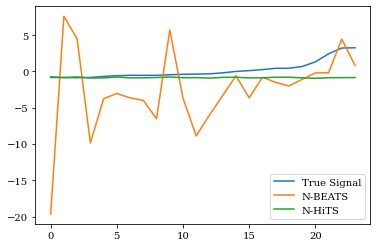

In [ ]:
w_idx = 0
u_idx = 0

plt.plot(y_true[u_idx,w_idx,:], label='True Signal')
plt.plot(y_hat_nbeats[u_idx,w_idx,:], label='N-BEATS')
plt.plot(y_hat_nhits[u_idx,w_idx,:], label='N-HiTS')
#plt.plot(y_true[:,0,2], label='True')
#plt.plot(best_nbeats[::24,:].flatten(), label='N-BEATS')
#plt.plot(best_rnn[::24,:].flatten(), label='RNN')
plt.legend()
plt.show()

Y_df.unique_id.unique() ['% WEIGHTED ILI' '%UNWEIGHTED ILI' 'AGE 0-4' 'AGE 5-24' 'ILITOTAL'
 'NUM. OF PROVIDERS' 'OT']


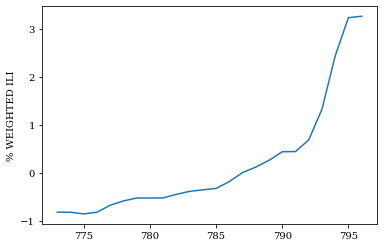

In [ ]:
print('Y_df.unique_id.unique()', Y_df.unique_id.unique())
ver = Y_df[Y_df.unique_id=='% WEIGHTED ILI']

plt.plot(ver.y[n_time-193:n_time-193+24])
plt.ylabel('% WEIGHTED ILI')
plt.show()

<a name="cell-5"></a>
### 5. Evaluate Results

In [ ]:
best_model

NHITS(
  (model): _NHITS(
    (blocks): ModuleList(
      (0): _NHITSBlock(
        (pooling_layer): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
        (layers): Sequential(
          (0): Linear(in_features=18, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=512, bias=True)
          (5): ReLU()
          (6): Linear(in_features=512, out_features=73, bias=True)
        )
        (basis): _IdentityBasis()
      )
      (1): _NHITSBlock(
        (pooling_layer): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=True)
        (layers): Sequential(
          (0): Linear(in_features=18, out_features=512, bias=True)
          (1): ReLU()
          (2): Linear(in_features=512, out_features=512, bias=True)
          (3): ReLU()
          (4): Linear(in_features=512, out_features=512, bias=True)
       

In [ ]:
# Y_forecast_df = Y_df[Y_df['ds']<'2016-12-27']
# X_forecast_df = X_df[X_df['ds']<'2016-12-28']

In [ ]:
# best_model.return_decomposition = False
# forecast_df = best_model.forecast(Y_df=Y_forecast_df, X_df=X_forecast_df, S_df=None, batch_size=2)
# forecast_df